In [654]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.base import TransformerMixin
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from catboost import CatBoostRegressor, CatBoostClassifier
from lightgbm.sklearn import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [655]:
# data downloaded from
df = pd.read_csv("./data/salaries_clean.csv", encoding="latin-1")
print(len(df))
df.head()

1655


,salary_id,employer_name,location_name,location_state,location_country,location_latitude,location_longitude,job_title,job_title_category,job_title_rank,total_experience_years,employer_experience_years,annual_base_pay,signing_bonus,annual_bonus,stock_value_bonus,comments,submitted_at
0,1,opower,"san francisco, ca",CA,US,37.77,-122.41,systems engineer,Engineering,NaN,13.0,2.0,125000.0,5000.0,0.0,5000 shares,Don't work here.,3/21/16 12:58
1,3,walmart,"bentonville, ar",AR,US,36.36,-94.20,senior developer,Software,Senior,15.0,8.0,65000.0,NaN,5000.0,"3,000",NaN,3/21/16 12:58
2,4,vertical knowledge,"cleveland, oh",OH,US,41.47,-81.67,software engineer,Software,NaN,4.0,1.0,86000.0,5000.0,6000.0,0,NaN,3/21/16 12:59
3,6,netapp,waltham,NaN,NaN,NaN,NaN,mts,Other,NaN,4.0,0.0,105000.0,5000.0,8500.0,0,NaN,3/21/16 13:00
4,12,apple,cupertino,NaN,NaN,NaN,NaN,software engineer,Software,NaN,4.0,3.0,110000.0,5000.0,7000.0,150000,NaN,3/21/16 13:02


In [656]:
# all the columns of df
print(list(df.columns))

['salary_id', 'employer_name', 'location_name', 'location_state', 'location_country', 'location_latitude', 'location_longitude', 'job_title', 'job_title_category', 'job_title_rank', 'total_experience_years', 'employer_experience_years', 'annual_base_pay', 'signing_bonus', 'annual_bonus', 'stock_value_bonus', 'comments', 'submitted_at']


### Splitting the data into training and testing sets

In [657]:
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=123
)
train_df = train_df.dropna(subset = ["annual_base_pay"])
test_df = test_df.dropna(subset = ["annual_base_pay"])

X_train = train_df.drop(columns=["salary_id", "location_state", "location_latitude", "location_longitude", 
                                "job_title", "signing_bonus", "annual_bonus", 
                                "stock_value_bonus", "comments", "submitted_at"]) # drop the uncnessary columns as well
y_train = train_df["annual_base_pay"]

X_test = test_df.drop(columns=["salary_id", "location_state", "location_latitude", "location_longitude", 
                                "job_title", "signing_bonus", "annual_bonus", 
                                "stock_value_bonus", "comments", "submitted_at"]) # drop the uncnessary columns as well
y_test = test_df["annual_base_pay"]

## since there are not that many NaN in "annual_base_pay" - we'll just drop them

display(X_train.head(10))
display(y_train.head())
print(X_train.shape[0], y_train.shape[0])

,employer_name,location_name,location_country,job_title_category,job_title_rank,total_experience_years,employer_experience_years,annual_base_pay
483,expedia,seattle,NaN,Software,2,3.0,3.0,105000.0
132,vmware,palo alto,NaN,Other,NaN,4.0,3.0,125000.0
1002,microsoft,redmond,NaN,Other,Senior,30.0,3.0,180000.0
72,conde nast,"new york city, ny",US,Software,2,8.0,4.0,112000.0
1215,microsoft,"redmond, wa",US,Software,NaN,1.5,1.5,110000.0
987,higher learning technology,iowa,US,Software,NaN,15.0,2.0,130000.0
1395,health ensurance company,germany,DE,Engineering,NaN,10.0,10.0,67200.0
903,disney interactive,"glendale, ca",US,Software,NaN,4.0,3.0,88000.0
440,state farm,"phoenix, az",US,Software,NaN,2.0,1.0,63000.0
116,facebook,menlo park,NaN,Software,NaN,3.0,1.0,150000.0


483     105000.0
132     125000.0
1002    180000.0
72      112000.0
1215    110000.0
Name: annual_base_pay, dtype: float64

1322 1322


# Visualization

### Visualization of annual base pay versus seniority 

**TODO - Anna: Explain why we're doing this visualization in a bit more detail + some analysis about the results**

We're going to alter `job_title_rank` columns just a little bit. Currently it has the following values: `["Senior", "Intern", "Junior", "2", "1", "3","4", "NaN"]` which does not tell us a whole much. We will change 1, 2, 3, 4 to `["SDE 1/2/3/4"]`, respectively. 

Furthermore, from looking at the data from columns `job_title` and `job_title_rank`, it seems that most `"NaN"` in the `job_title_rank` should be associated with `Junior` rank by looking at the associated values in `job_title`. Combined with this [article](https://newsletter.pragmaticengineer.com/p/growing-a-junior-team) by Gergely Orosz, there's often more Junior Engineers at a company than Senior Engineers. For these reasons, we'll also impute the `"NaN"` in the `job_title_rank` column to be `"Junior"`

In [658]:
viz_data = train_df.copy()

# before transformation
print(viz_data["job_title_rank"].value_counts(dropna=False))

def transform_rank(x):
    if x in {"1", "2", "3", "4"}:
        # print(x)
        return "SDE {}".format(x) 
    elif pd.isnull(x):
        return "Junior"
    else:
        return str(x)

viz_data["job_title_rank"] = viz_data["job_title_rank"].map(transform_rank)

# after transformation
print()
print(viz_data["job_title_rank"].value_counts())

NaN       990
Senior    200
2          53
1          31
3          16
Intern     14
Junior     13
4           5
Name: job_title_rank, dtype: int64

Junior    1003
Senior     200
SDE 2       53
SDE 1       31
SDE 3       16
Intern      14
SDE 4        5
Name: job_title_rank, dtype: int64


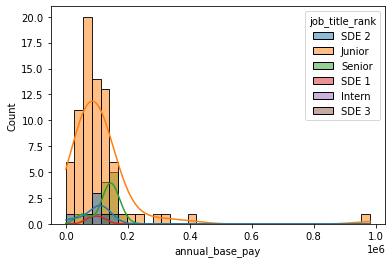

In [659]:
fig, ax = plt.subplots()
sns.histplot(x='annual_base_pay', data=viz_data.head(100), ax=ax, kde=True, hue='job_title_rank')

plt.show()

### Visualization of annual base pay versus different job title

**TODO - Anna: Explain why we're doing this visualization in a bit more detail + some analysis about the results**

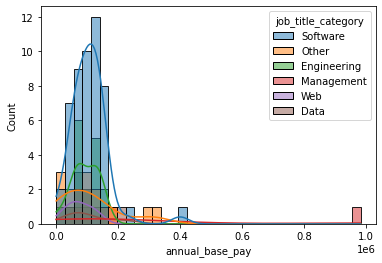

In [678]:
viz_data = train_df.copy()
fig, ax = plt.subplots()
sns.histplot(x='annual_base_pay', data=viz_data.head(100), ax=ax, kde=True, hue='job_title_category')
plt.show()

### Visualization of annual base pay versus different country

**TODO - Anna: Explain why we're doing this visualization in a bit more detail + some analysis about the results**

Again, there are some missing data so We'll also be imputing `"NaN"` from the `"location_country"` with the most common occurence - which is the US

In [677]:
viz_data = train_df.copy()
countries = viz_data["location_country"].value_counts(dropna=False)
print("Before transformation")
print(countries[:3])

def transform_country(x):
    if pd.isnull(x):
        return "US"
    else:
        return x 
    
viz_data["location_country"] = viz_data["location_country"].map(transform_country)
countries = viz_data["location_country"].value_counts(dropna=False)
print("\nAfter transformation")
print(countries[:3])

Before transformation
NaN    694
US     436
CA      33
Name: location_country, dtype: int64

After transformation
US    1130
CA      33
DE      19
Name: location_country, dtype: int64


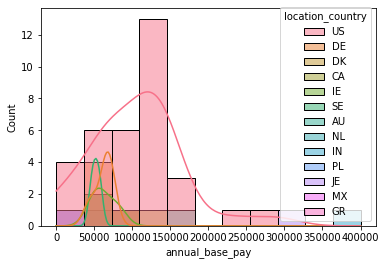

In [679]:
fig, ax = plt.subplots()
sns.histplot(x='annual_base_pay', data=viz_data.head(100), ax=ax, kde=True, hue='location_country')
plt.show()

### Visualization of annual base pay versus total years of experience

**TODO - Anna: Explain why we're doing this visualization in a bit more detail + some analysis about the results**
**TOOD - Anna: choose 1 of the following bar plots - up to you for which one is better**

For visualization's sake, we believe that for `years_of_experience` - it would make sense to group them into buckets as opposed to leaving it as a continuous variable.

In [681]:
viz_data = train_df.copy()
yoe = viz_data["total_experience_years"].value_counts(dropna=False)
print("Before transformation")
print(yoe[:5])

def yoe_transformation(x):
    if x < 1:
        return "< 1"
    elif 1 <= x < 3:
        return "1 - 3"
    elif 3 <= x < 5:
        return "3 - 5"
    elif 5 <= x <= 10:
        return "5 - 10"
    else:
        return "10 +"
        
viz_data["total_experience_years"] = viz_data["total_experience_years"].transform(yoe_transformation)
yoe = viz_data["total_experience_years"].value_counts(dropna=False)
print("\nAfter transformation")
print(yoe)

Before transformation
3.0    132
5.0    131
Name: total_experience_years, dtype: int64

After transformation
5 - 10    516
10 +      265
3 - 5     252
1 - 3     240
< 1        51
Name: total_experience_years, dtype: int64


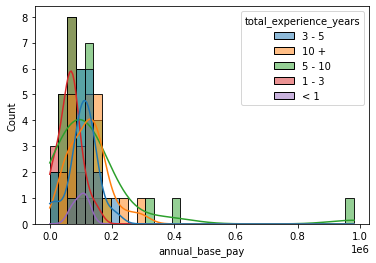

In [684]:
fig, ax = plt.subplots()
sns.histplot(x='annual_base_pay', data=viz_data.head(100), ax=ax, kde=True, hue='total_experience_years')
plt.show()

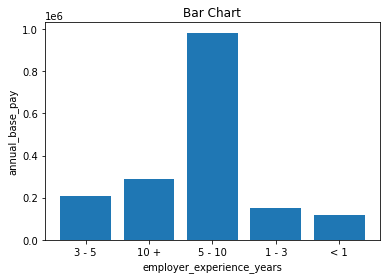

In [685]:
fig, ax = plt.subplots()
 
# Bar chart with day against tip
plt.bar(viz_data.head(100)['total_experience_years'], viz_data.head(100)['annual_base_pay'])
 
plt.title("Bar Chart")
 
# Setting the X and Y labels
plt.xlabel('employer_experience_years')
plt.ylabel('annual_base_pay')
 
# Adding the legends
plt.show()

# Pre-processing

First, declaring my own imputer

In [660]:
class CustomImputer(TransformerMixin):
    def fit(self, X, y):
        self.companies_set = set(X["employer_name"].value_counts().sort_values(ascending = False)[:20])
        self.location_set = set(X["location_name"].value_counts().sort_values(ascending = False)[20:])
        return self 

    def transform(self, X):
        X_copy = X.copy()
        X_copy["job_title_rank"] = X_copy["job_title_rank"].map(self.transform_rank)
        X_copy["location_country"] = X_copy["location_country"].map(self.transform_country)
        X_copy["employer_name"] = X_copy["employer_name"].map(self.transform_employer)
        X_copy["location_name"] = X_copy["location_name"].map(self.transform_location)
        # X["total_experience_years"] = X["total_experience_years"].transform(self.transform_yoe)
        return X_copy


    def transform_rank(self, x):
        if x in {"1", "2", "3", "4"}:
            # print(x)
            return "SDE {}".format(x) 
        elif pd.isnull(x):
            return "Junior"
        else:
            return str(x)

    def transform_country(self, x):
        if pd.isnull(x):
            return "US"
        else:
            return x 
        
    def transform_yoe(self, x):
        if x < 1:
            return "< 1"
        elif 1 <= x < 3:
            return "1 - 3"
        elif 3 <= x < 5:
            return "3 - 5"
        elif 5 <= x <= 10:
            return "5 - 10"
        else:
            return "10 +"
    
    def transform_employer(self, x):
        if x in self.companies_set:
            return x 
        else:
            return "Other"

    def transform_location(self, x):
            if x in self.location_set:
                return x 
            else:
                return "Other"

Defining a Column Transformer to apply the correct pre-processing depending on the type of the columns. We'll be applying One Hot Encoding to the categorical features and scaling and imputation to numerical features. Finally, we're applying Ordinal Encoding to the ordinal features.

In [661]:
categorical_features = ["employer_name", "location_name", "location_country", "job_title_category"]
numerical_features = ["employer_experience_years", "total_experience_years"]
ordinal_features = ["job_title_rank"]

title_rank_levels = ["Intern", "SDE 1", "SDE 2", "Junior", "SDE 3", "Senior", "SDE 4"]

categorical_transformer = OneHotEncoder(handle_unknown="ignore")
ordinal_transformer = OrdinalEncoder(categories=[title_rank_levels])
numerical_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())


ct = make_column_transformer(
    (numerical_transformer, numerical_features),
    (categorical_transformer, categorical_features),
    (ordinal_transformer, ordinal_features),
)


Example of declaring a pipeline that utilizes both our custom imputer and the column transformer

In [662]:

pipeline = make_pipeline(
    CustomImputer(),
    ct
)

transformed_X = pipeline.fit_transform(X_train, y_train)
column_names = numerical_features + list(
    ct.named_transformers_["onehotencoder"].get_feature_names_out(
        categorical_features
    )) + list(
        ct.named_transformers_["ordinalencoder"].get_feature_names_out(
        ordinal_features
    )
)

# pd.DataFrame(temp, columns = column_names)

transformed_X_train = pd.DataFrame(transformed_X.toarray(), columns = column_names)
transformed_X_train.head()



,employer_experience_years,total_experience_years,employer_name_Other,location_name_Other,location_country_AR,location_country_AU,location_country_BE,location_country_BG,location_country_BM,location_country_BR,...,location_country_ZA,job_title_category_Applied Science,job_title_category_Data,job_title_category_Engineering,job_title_category_Management,job_title_category_Operations,job_title_category_Other,job_title_category_Software,job_title_category_Web,job_title_rank
0,0.086653,-0.662216,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
1,0.086653,-0.485939,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0
2,0.086653,4.097259,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0
3,0.383051,0.219169,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
4,-0.357944,-0.926631,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0


In [663]:
len(transformed_X_train)

1322

# Modelling

### Logistic Regression

The first model we'll be trying out is logistic regression from `sklearn`. We'll first perform hyperparemeter tuning and cross validation on the model to pick the best `C` value

Note: code is inspired from my notes taken from CPSC 330 by Varada Kolhatkar

In [664]:
scores_dict = {
    "alpha": 10.0 ** np.arange(-5, 5, 1),
    "mean_train_scores": list(),
    "mean_cv_scores": list(),
}

for alpha in scores_dict["alpha"]:
    pipe_ridge = make_pipeline(
        CustomImputer(),
        ct,
        Ridge(alpha=alpha)
    )
    scores = cross_validate(pipe_ridge, X_train, y_train, return_train_score=True)
    scores_dict["mean_train_scores"].append(scores["train_score"].mean())
    scores_dict["mean_cv_scores"].append(scores["test_score"].mean())

results_df = pd.DataFrame(scores_dict)
results_df

,alpha,mean_train_scores,mean_cv_scores
0,0.00001,0.020500,-18444.193340
1,0.00010,0.020499,-18349.365651
2,0.00100,0.020500,-18443.366067
3,0.01000,0.020500,-18435.739136
4,0.10000,0.020490,-18288.493332
5,1.00000,0.020271,-17961.128570
6,10.00000,0.019210,-16899.878617
7,100.00000,0.018042,-13458.361233
8,1000.00000,0.012751,-5574.611533
9,10000.00000,0.003327,-1392.230116


We will now run the funal model on testing set using the hyperparameter $\alpha = 0.001$ (because it yielded the "best" results)

In [665]:
a = results_df.loc[results_df["mean_cv_scores"].idxmax()]["alpha"]
print("alpha =", a)

final_ridge_pipe = make_pipeline(
    CustomImputer(),
    ct,
    Ridge(alpha=a)
)

final_ridge_pipe.fit(X_train, y_train)
preds = final_ridge_pipe.predict(X_test)
# # print(preds)
rmse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
print("RMSE:", rmse)
print("R^2 = ", r2)

alpha = 10000.0
RMSE: 137905776650836.62
R^2 =  -0.8628705942691091


### LightGBM

Next, we'll be trying the `LGBMRegressor` model. 

In [666]:
lgbm_pipe = make_pipeline(
    CustomImputer(),
    ct,
    LGBMRegressor(random_state=2022)
)

lgbm_pipe.fit(X_train, y_train)
preds = lgbm_pipe.predict(X_test)

rmse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
print("RMSE:", rmse)
print("R^2 = ", r2)

RMSE: 6052746040949590.0
R^2 =  -80.76222119260555


### CatBoost

In [667]:
catboost_pipe = make_pipeline(
    CustomImputer(),
    ct,
    CatBoostRegressor()
)

catboost_pipe.fit(X_train, y_train)
preds = catboost_pipe.predict(X_test)

rmse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
print("RMSE:", rmse)
print("R^2 = ", r2)


Learning rate set to 0.042789
0:	learn: 272581688.7498887	total: 1.21ms	remaining: 1.21s
1:	learn: 270251432.9462987	total: 1.54ms	remaining: 771ms
2:	learn: 267355053.8981989	total: 1.86ms	remaining: 619ms
3:	learn: 264490119.9151508	total: 2.18ms	remaining: 542ms
4:	learn: 261656176.1866405	total: 2.49ms	remaining: 496ms
5:	learn: 258852904.7517140	total: 2.8ms	remaining: 464ms
6:	learn: 256079940.7566673	total: 3.06ms	remaining: 435ms
7:	learn: 253336951.9816355	total: 3.4ms	remaining: 422ms
8:	learn: 250623506.2571076	total: 3.65ms	remaining: 402ms
9:	learn: 247939537.6609740	total: 3.98ms	remaining: 395ms
10:	learn: 245284337.7130240	total: 4.28ms	remaining: 385ms
11:	learn: 242657818.4421304	total: 4.63ms	remaining: 381ms
12:	learn: 240059563.8457924	total: 5.01ms	remaining: 380ms
13:	learn: 237489288.9061862	total: 5.33ms	remaining: 375ms
14:	learn: 234946743.4217421	total: 5.62ms	remaining: 369ms
15:	learn: 232431518.6921553	total: 6.06ms	remaining: 373ms
16:	learn: 229943400.9

### Random Forest

In [668]:
rf_pipe = make_pipeline(
    CustomImputer(),
    ct,
    RandomForestRegressor(random_state=2022, n_jobs=-1)
)

rf_pipe.fit(X_train, y_train)
preds = rf_pipe.predict(X_test)

rmse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
print("RMSE:", rmse)
print("R^2 = ", r2)


RMSE: 74403575098305.02
R^2 =  -0.005064729884793451


# Conclusion and Further Research

As you can see, the results achieved by all these different models were below par at best. We believe this may be due to [TODO]. For the future, we believe we can improve model performance by [TODO]

However, experiementing further, we wanted to see how well different ML models would perform if we tweak the research question to be "Predict whether employee will make more than \$100k annual base salary

In [669]:
df = pd.read_csv("./data/salaries_clean.csv", encoding="latin-1")
df.dropna(subset = ["annual_base_pay"])
df["more_than_100k"] = df["annual_base_pay"].transform(lambda x: x > 100000)
df.head()

,salary_id,employer_name,location_name,location_state,location_country,location_latitude,location_longitude,job_title,job_title_category,job_title_rank,total_experience_years,employer_experience_years,annual_base_pay,signing_bonus,annual_bonus,stock_value_bonus,comments,submitted_at,more_than_100k
0,1,opower,"san francisco, ca",CA,US,37.77,-122.41,systems engineer,Engineering,NaN,13.0,2.0,125000.0,5000.0,0.0,5000 shares,Don't work here.,3/21/16 12:58,True
1,3,walmart,"bentonville, ar",AR,US,36.36,-94.20,senior developer,Software,Senior,15.0,8.0,65000.0,NaN,5000.0,"3,000",NaN,3/21/16 12:58,False
2,4,vertical knowledge,"cleveland, oh",OH,US,41.47,-81.67,software engineer,Software,NaN,4.0,1.0,86000.0,5000.0,6000.0,0,NaN,3/21/16 12:59,False
3,6,netapp,waltham,NaN,NaN,NaN,NaN,mts,Other,NaN,4.0,0.0,105000.0,5000.0,8500.0,0,NaN,3/21/16 13:00,True
4,12,apple,cupertino,NaN,NaN,NaN,NaN,software engineer,Software,NaN,4.0,3.0,110000.0,5000.0,7000.0,150000,NaN,3/21/16 13:02,True


In [670]:
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=123
)

X_train = train_df.drop(columns=["salary_id", "location_state", "location_latitude", "location_longitude", 
                                "job_title", "signing_bonus", "annual_bonus", 
                                "stock_value_bonus", "comments", "submitted_at", "annual_base_pay"]) # drop the uncnessary columns as well
y_train = train_df["more_than_100k"]

X_test = test_df.drop(columns=["salary_id", "location_state", "location_latitude", "location_longitude", 
                                "job_title", "signing_bonus", "annual_bonus", 
                                "stock_value_bonus", "comments", "submitted_at", "annual_base_pay"]) # drop the uncnessary columns as well
y_test = test_df["more_than_100k"]

In [671]:
scores_dict = {
    "C": 10.0 ** np.arange(-4, 6, 1),
    "mean_train_scores": list(),
    "mean_cv_scores": list(),
}
for C in scores_dict["C"]:
    pipe_ridge = make_pipeline(
        CustomImputer(),
        ct,
        LogisticRegression(C=C)
    )
    scores = cross_validate(pipe_ridge, X_train, y_train, return_train_score=True)
    scores_dict["mean_train_scores"].append(scores["train_score"].mean())
    scores_dict["mean_cv_scores"].append(scores["test_score"].mean())

results_df = pd.DataFrame(scores_dict)
results_df

,C,mean_train_scores,mean_cv_scores
0,0.0001,0.519826,0.519637
1,0.0010,0.611405,0.598931
2,0.0100,0.645961,0.631432
3,0.1000,0.670884,0.663139
4,1.0000,0.670127,0.660109
5,10.0000,0.673527,0.660109
6,100.0000,0.672393,0.655577
7,1000.0000,0.673149,0.658596
8,10000.0000,0.672015,0.656332
9,100000.0000,0.674848,0.655577


In [672]:
C = results_df.loc[results_df["mean_cv_scores"].idxmax()]["C"]
print("C =", C)

final_lr_pipe = make_pipeline(
    CustomImputer(),
    ct,
    LogisticRegression(C=C)
)

final_lr_pipe.fit(X_train, y_train)
preds = final_lr_pipe.predict(X_test)
score = accuracy_score(y_test, preds)

print("Accuracy:", score)

C = 0.1
Accuracy: 0.6978851963746223


In [673]:
pipe_lgbm = make_pipeline(
    CustomImputer(),
    ct,
    LGBMClassifier()
)

param_grid = {
    "lgbmclassifier__num_leaves": [5, 10, 31, 100, 1000, 10000],
    "lgbmclassifier__max_depth": [-1, 0, 5, 10, 20, 30, 40]
}

random_search = RandomizedSearchCV(
    pipe_lgbm, param_distributions=param_grid, n_jobs=-1, n_iter=20, cv=5, random_state=2022
)
random_search.fit(X_train, y_train);

pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_lgbmclassifier__num_leaves",
        "param_lgbmclassifier__max_depth",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,1,3,3,5,5,7,8,9,9,9,12,12,12,12,12,12,12,12,20
mean_test_score,0.671458,0.671458,0.665417,0.665417,0.661644,0.661644,0.656364,0.652559,0.645014,0.645014,0.645014,0.641232,0.641232,0.641232,0.641232,0.641232,0.641232,0.641232,0.641232,0.636707
param_lgbmclassifier__num_leaves,100,10000,10,10,5,5,10,31,100,1000,10000,100,10000,1000,100,1000,100,10000,10000,31
param_lgbmclassifier__max_depth,5,5,20,0,5,-1,5,10,10,10,10,-1,40,0,0,-1,40,-1,30,20
mean_fit_time,0.022175,0.022766,0.037324,0.031865,0.016574,0.023538,0.049352,0.0335,0.033279,0.061373,0.073834,0.043333,0.408009,0.062635,0.048991,0.071925,0.050086,0.277543,0.435626,0.040516


In [674]:
print(random_search.best_params_)
num_leaves = random_search.best_params_["lgbmclassifier__num_leaves"]
max_depth = random_search.best_params_["lgbmclassifier__max_depth"]

final_lgbm_pipe = make_pipeline(
    CustomImputer(),
    ct,
    LGBMClassifier(num_leaves=num_leaves, max_depth=max_depth)
)

final_lgbm_pipe.fit(X_train, y_train)
preds = final_lgbm_pipe.predict(X_test)
score = accuracy_score(y_test, preds)

print("Accuracy:", score)

{'lgbmclassifier__num_leaves': 10000, 'lgbmclassifier__max_depth': 5}
Accuracy: 0.6978851963746223


In [675]:
pipe_rf = make_pipeline(
    CustomImputer(),
    ct,
    RandomForestClassifier()
)

param_grid = {
    "randomforestclassifier__max_depth": [10, 20, 30, 40, 50],
    "randomforestclassifier__n_estimators": [200, 400, 600, 800, 1000]
}

random_search = RandomizedSearchCV(
    pipe_rf, param_distributions=param_grid, n_jobs=-1, n_iter=20, cv=5, random_state=2022
)
random_search.fit(X_train, y_train)

pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_randomforestclassifier__max_depth",
        "param_randomforestclassifier__n_estimators",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,6,8,9,10,11,12,13,14,15,16,17,18,19,20
mean_test_score,0.671444,0.668419,0.66691,0.666161,0.665397,0.641987,0.641987,0.641235,0.641226,0.640477,0.640463,0.639723,0.639717,0.638962,0.63745,0.636698,0.634434,0.634434,0.632925,0.629142
param_randomforestclassifier__max_depth,10,10,10,10,10,40,30,50,20,50,20,20,30,40,30,40,20,30,20,50
param_randomforestclassifier__n_estimators,200,1000,800,400,600,200,1000,1000,600,400,800,200,600,1000,200,800,1000,400,400,200
mean_fit_time,0.244638,1.237268,0.972312,0.474884,0.708308,0.377761,2.10308,2.190989,1.103096,0.800115,1.541982,0.361431,1.127599,2.012382,0.376039,1.26801,1.768922,0.801699,0.734193,0.417638


In [676]:
print(random_search.best_params_)
max_depth = random_search.best_params_["randomforestclassifier__max_depth"]
n_estimators = random_search.best_params_["randomforestclassifier__n_estimators"]

final_rf_pipe = make_pipeline(
    CustomImputer(),
    ct,
    RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators)
)

final_rf_pipe.fit(X_train, y_train)
preds = final_rf_pipe.predict(X_test)
score = accuracy_score(y_test, preds)

print("Accuracy:", score)

{'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__max_depth': 10}
Accuracy: 0.7129909365558912


# Final Remarks

[TODO]